In [1]:
from BSF import I_direct_cone
from utils import calc_dependent_params
import numpy as np
import matplotlib.pyplot as plt
from utils import Interpolator
from BSF import calc_I_fiber

In [2]:
params = {
    # natural constants & optical params
    "c0": 0.299792458, #(* um/fs *),
    # tissue properties
    "ntissue": 1.36, # refractive index of cortical tissue
    "mu_a": 0.00006, # um**-1
    "mu_s": 0.0211, # um**-1
    "g": 0.86, # anisotropy
    # optical fiber
    "NA": 0.37, # num aperture
    "opt_radius": 100, # fiber radius in um
    
    
    # final volume, NOTE: choose xymax to be 100um larger than your desired 
    #                     volume to avoid artifacts from disk convolution.
    #                     Check docstring of disk_conv_nproll in utils.py for
    #                     more information.
    'xymax':  700,
    'dxy':   5,
    'zmax':   700,
    'dz':    5,

    
    # Calculation of scattered pencil beam
    # exp.-sampling of rho
    "rho_exp_smpl" : True,
    "rhoexpmin": 1, # exp(linspace(log(rhomin), log(rhomax), n_rhosmpls)) if exp-smpl True
    "n_rhosmpls" : 20, # (line above)
    "rhostep": 2, # stepsize if exp-smpl False
    
    # multipath-time integral
    "tau_exp_smpl": True,
    "taumin": 5,  # fs 
    "taumax": 10000, # fs
    "n_tausmpls": 100, # if exp-smpl True, see definition of exp-sampling for rho above
    "taustep": 500, # fs stepsize if exp-smpl False
    
    "mu_tau": "eq4", # which equations to use to calculate the first moment 
                                   # of time dispersion, mu. Should be one of
                                   # 'eq4'               > McLean eq. 4
                                   # 'table1_vandeHulst' 
                                   #             -> McLean table1 van de Hulst & Kattawar
                                   # 'table1_Lutomirski' 
                                   #  -> McLean table1 Dolin, Ishimaru, Lutomirski et al.
    
    # angular convolution
    "nstepstheta": 24,  # ang conv steps
    "nstepsphi"  : 24,
}
params = calc_dependent_params(params)
results = calc_I_fiber(params)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.50s/it]


In [6]:
cone = results['cone']
scattered_cone_interp = Interpolator(
        cone['rho'], cone['z'], cone['scattered'],
    )

In [21]:
def disk_convolution_center(z, params, n_disk_samples, I_in_rho_z):
    # center -> rho=0
    rho = np.zeros(z.shape)
    # define num integral
    dr = params['opt_radius'] / (n_disk_samples-1)
    rs = np.arange(0, params['opt_radius']+dr, dr)
    dphi = 2 * np.pi 
    I = np.zeros(z.shape)
    for r in rs:
        I += I_in_rho_z(rho+r, z) * dr * r * dphi
    return I
def I_direct_cone_fixed_params(rho, z):
    return I_direct_cone(z, rho, params)

direct_cone_interp = Interpolator(
        cone['rho'], cone['z'], I_direct_cone_fixed_params(cone['rho'], cone['z'])
    )

(0.0, 100.0)

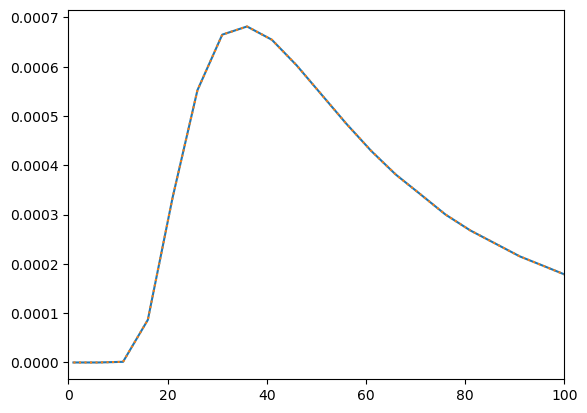

In [8]:
plt.plot(cone['z'][0], cone['scattered'][0])
z=np.arange(700)
plt.plot(z, scattered_cone_interp.calc(np.zeros(z.shape), z), ls='dotted')
plt.xlim(0,100)

In [54]:
rho=np.array([10])
z=np.array([8])
scattered_cone_interp.calc(rho, z)

array([9.90079319e-07])

In [ ]:
rho = np.zeros((500))
z = np.arange(500)
I_direct = disk_convolution_center(z, params, n_disk_samples=1e4, I_in_rho_z=I_direct_cone_fixed_params)

In [37]:
from time import time
a=time()
z = np.arange(500)
I_scat2 = disk_convolution_center(z, params, n_disk_samples=2, I_in_rho_z=scattered_cone_interp.calc)
I_scat5 = disk_convolution_center(z, params, n_disk_samples=5, I_in_rho_z=scattered_cone_interp.calc)
I_scat10 = disk_convolution_center(z, params, n_disk_samples=10, I_in_rho_z=scattered_cone_interp.calc)
I_scat20 = disk_convolution_center(z, params, n_disk_samples=20, I_in_rho_z=scattered_cone_interp.calc)
print(time()-a)

11.262329816818237


In [22]:
I_interp_direct = disk_convolution_center(z, params, n_disk_samples=1e4, I_in_rho_z=direct_cone_interp.calc)

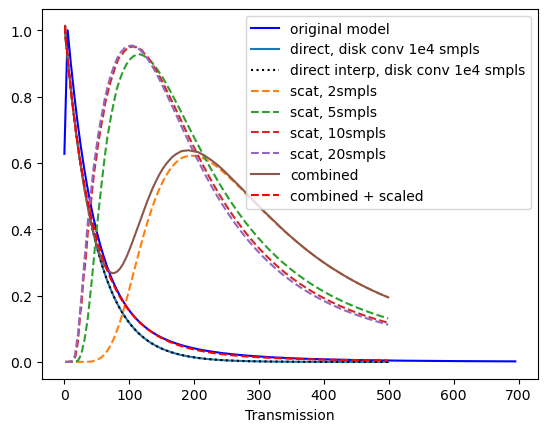

In [38]:
fig, ax = plt.subplots()
from scipy.io import loadmat
matlab_data = loadmat('matlab/output3D_26_08_2024.mat')['out']
matlab_data_xz = matlab_data[:,int(matlab_data.shape[1]/2),:]
matlab_dx = 5
matlab_x = np.arange(-80*matlab_dx,81*matlab_dx,matlab_dx)
matlab_z = np.arange(0,140*5,5)
matlab_xx, matlab_zz = np.meshgrid(matlab_x, matlab_z, indexing='ij')
ax.plot(matlab_z, matlab_data_xz[int(matlab_data.shape[0]/2), :], 
            ls='solid', color='blue', label='original model')


ax.plot(z, I_direct, ls='solid', label='direct, disk conv 1e4 smpls')
ax.plot(z, I_direct, ls='dotted', color='black', label='direct interp, disk conv 1e4 smpls')
ax.plot(z, I_scat2, ls='dashed', label='scat, 2smpls')
ax.plot(z, I_scat5, ls='dashed', label='scat, 5smpls')
ax.plot(z, I_scat10, ls='dashed', label='scat, 10smpls')
ax.plot(z, I_scat20, ls='dashed', label='scat, 20smpls')
ax.plot(z, I_scat+I_direct, ls='solid', label='combined')
ax.plot(z, I_scat20*(1 - np.cos(params['theta_div']))+I_direct, ls='dashed', color='red', label='combined + scaled')
ax.set_xlabel('Depth z [µm]')
ax.set_xlabel('Transmission')
ax.legend()
plt.show()

np.float64(0.03771937744762188)